## TC 5033
### Word Embeddings

<br>

#### Activity 3b: Text Classification using RNNs and AG_NEWS dataset in PyTorch
<br>

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested.

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%):
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


### Import libraries

In [1]:
# conda install -c pytorch torchtext
# conda install -c pytorch torchdata
# conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch

### Google Colab
!conda install -c pytorch torchtext==0.8 torchaudio cudatoolkit=10.2 -c pytorch
!pip install portalocker==2.2
!pip install scikit-plot

/bin/bash: line 1: conda: command not found


In [2]:
# The following libraries are required for running the given code
# Please feel free to add any libraries you consider adecuate to complete the assingment.
import numpy as np
#PyTorch libraries
import torch
from torchtext.datasets import AG_NEWS
# Dataloader library
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as Fs
import torch.nn.functional as F

# These libraries are suggested to plot confusion matrix
# you may use others
import scikitplot as skplt
import matplotlib.pyplot as plt
import gc

In [3]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Get the train and the test datasets and dataloaders

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

In [4]:
train_dataset, test_dataset = AG_NEWS()

In [5]:
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [6]:
# Get the tokeniser
# tokeniser object
tokeniser = get_tokenizer('basic_english')

def yield_tokens(data):
    for _, text in data:
        yield tokeniser(text)

In [7]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])

In [8]:
#test tokens
tokens = tokeniser('Welcome to Team7')
print(tokens, vocab(tokens))

['welcome', 'to', 'team7'] [3314, 4, 0]


In [9]:
NUM_TRAIN = int(len(train_dataset)*0.9)
NUM_VAL = len(train_dataset) - NUM_TRAIN

In [10]:
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

In [11]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

108000 12000 7600


In [12]:
# function passed to the DataLoader to process a batch of data as indicated
def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))

    # Create list with indices from tokeniser
    x = [vocab(tokeniser(text)) for text in x]
    x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    # Prepare the labels, by subtracting 1 to get them in the range 0-3
    return torch.tensor(x, dtype=torch.int32), torch.tensor(y, dtype=torch.int32) - 1

In [13]:
labels =  ["World", "Sports", "Business", "Sci/Tech"]
max_tokens = 50
BATCH_SIZE = 256

In [14]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)

In [15]:
train_dataset.dataset

<torchtext.data.functional.to_map_style_dataset.<locals>._MapStyleDataset at 0x7a1b1a4fe950>

### Let us build our RNN model

In [16]:
EMBEDDING_SIZE = 64
NEURONS = 12
LAYERS = 2
NUM_CLASSES = 4

In [17]:
class RNN_Model_1(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes):
        super().__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=len(vocab),
                                            embedding_dim=embed_size)

        self.rnn = torch.nn.RNN(embed_size,hidden, layers, batch_first=True) # complete this code/
                        # You may use PyTorch nn.GRU(), nn.RNN(), or nn.LSTM()

        self.fc = nn.Linear(hidden, num_classes) # complete output classifier layer using linear layer

    def forward(self, x):

        batch_size = x.size(0)
        x = self.embedding_layer(x)
        x,h = self.rnn(x)
        return self.fc(x.mean(dim=1))
        # implement forward pass. This function will be called when executing the model

In [18]:
def accuracy(model, loader):#modelo y un dataloader que nos va a permitir iterar a traves de los datos, a traves de los minibatches
  num_correct = 0 #numeros de correctas
  num_total = 0 #numeros de imagenes totales
  model.eval() #modelo en modo evaluación, algunas capas se comportan difernete en modo de evaluación o en modo entrenamiento como la capa batch normalization, solo interesa accuracy, no nos interesa entrenar
  model = model.to(device=device) #asegruarnos que el modelo este en el dispositivo gpu que estamos utilizando para entrenar
  with torch.no_grad(): #no vamos a calcular el gradiente, porque estamos calculando el accuracy
      for xi, yi in loader: #mandamos a generar los minibatches directamente del Dataloader
          xi = xi.to(device=device, dtype = torch.long) #pasar los datos a GPU, tanto imagenes como etiquetas
          yi = yi.to(device=device, dtype = torch.long) #etiquetas
          scores = model(xi) #corremos modelos y nos regresa los score
          _, pred = scores.max(dim=1) #de los scores sacamos cual es el que tiene el max score, nos regresa el indice del elemento para todos los elementos del minibatch, indice nos representa la clase
          num_correct += (pred == yi).sum() #se compara la prediccion directamente con la clase correcta para todos los elementos del minibatch , en este caso 64 elementos, 1 donde corresponde, 0 donde no corresponde
          #se suman y se acumulan en la variable num_correct, de 64 elementos de un minibatch, 55 son correctos, nos acumula esos 55
          num_total += pred.size(0) #total de elementos

      return float(num_correct)/num_total

In [19]:
def train(model, optimiser, epochs=100):

  model = model.to(device=device) #pasar modelo a nuestro dispositivo
  for epoch in range(epochs): #loop para numero de epochs
      for i, (xi, yi) in enumerate(train_loader):#sacar elementos del dataloader de train
          model.train() #modo entrenamiento
          xi = xi.to(device=device, dtype=torch.long) #pasar imagenes a memoria
          yi = yi.to(device=device, dtype=torch.long)#pasar etiquetas a memoria
          scores = model(xi)#corremos modelos y nos regresa los score
          # funcion cost
          cost = F.cross_entropy(input= scores, target=yi) #función de costos
          optimiser.zero_grad() #borramos los gradientes ya calculados
          cost.backward() #mandar a llamar la función backward que nos calcula los gradientes para todos los parametros del modelo
          #es decir los gradientes de la funcion de costo con respecto a todos los parametros del modelo
          optimiser.step() #step que nos va hacer la actualización de nuestros parametros de acuerdo al optimiser que utilicemos
      acc= accuracy(model, val_loader) #calcular accuracy llamando las funcion pero con los datos de validación
      print(f'Epoch:{epoch}, costo: {cost.item()}, accuracy:{acc},') #imprimir cada epoch

In [20]:
epochs = 10
lr = 0.01
# instantiate model
rnn_model = RNN_Model_1(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES)
optimiser = torch.optim.Adam(rnn_model.parameters(), lr=lr)

In [21]:
train(rnn_model, optimiser=optimiser,  epochs=epochs)

Epoch:0, costo: 0.3338720202445984, accuracy:0.8875,
Epoch:1, costo: 0.16996432840824127, accuracy:0.8961666666666667,
Epoch:2, costo: 0.16338209807872772, accuracy:0.8924166666666666,
Epoch:3, costo: 0.22196020185947418, accuracy:0.8766666666666667,
Epoch:4, costo: 0.19302166998386383, accuracy:0.8878333333333334,
Epoch:5, costo: 0.1278735250234604, accuracy:0.88425,
Epoch:6, costo: 0.22350454330444336, accuracy:0.8891666666666667,
Epoch:7, costo: 0.0785054937005043, accuracy:0.8886666666666667,
Epoch:8, costo: 0.05128953978419304, accuracy:0.8916666666666667,
Epoch:9, costo: 0.14163589477539062, accuracy:0.8845,


In [22]:
print(f'{accuracy(rnn_model, test_loader):.4f}')

0.8828


In [95]:
def sample_text(model, loader):
    model.eval()
    for xi, yi in loader:
        #data = xi.cpu().numpy()
        xi = xi.to(device=device, dtype=torch.long)
        yi = yi.to(device=device, dtype=torch.long)

        scores = model(xi)
        _, pred = scores.max(dim=1)
        print(f'El texto Predicho es de categoría: {labels[pred[0]]}, el Original es: {labels[yi[0]]}')
        #print(f'Sample Text Classification Original: {labels[yi[0]]}')
    #print(xi, "\n") #es un tensor
    #print(data[2]) #tensor a lista
    #print(test_loader.pin_memory_device)
    #print(labels[pred[0]], "\n")
    #print(pred, "\n", yi)

In [92]:
#dir(vocab.vocab.itos_.index)
#dir(vocab.vocab)
#dir(vocab.vocab.itos_)
#vocab.vocab.itos_.count
#help(vocab.vocab.itos_)
#dir(test_loader)
#print(test_loader.dataset)
#dir(rnn_model.rnn)

In [96]:
sample_text(rnn_model, test_loader)

El texto Predicho es de categoría: Sci/Tech, el Original es: Sci/Tech
El texto Predicho es de categoría: Business, el Original es: Business
El texto Predicho es de categoría: Sports, el Original es: Sports
El texto Predicho es de categoría: Sci/Tech, el Original es: Sci/Tech
El texto Predicho es de categoría: Sports, el Original es: Sports
El texto Predicho es de categoría: World, el Original es: World
El texto Predicho es de categoría: World, el Original es: World
El texto Predicho es de categoría: World, el Original es: World
El texto Predicho es de categoría: Business, el Original es: Business
El texto Predicho es de categoría: Business, el Original es: Business
El texto Predicho es de categoría: Sports, el Original es: Sports
El texto Predicho es de categoría: World, el Original es: World
El texto Predicho es de categoría: Sci/Tech, el Original es: Sci/Tech
El texto Predicho es de categoría: World, el Original es: World
El texto Predicho es de categoría: World, el Original es: Worl

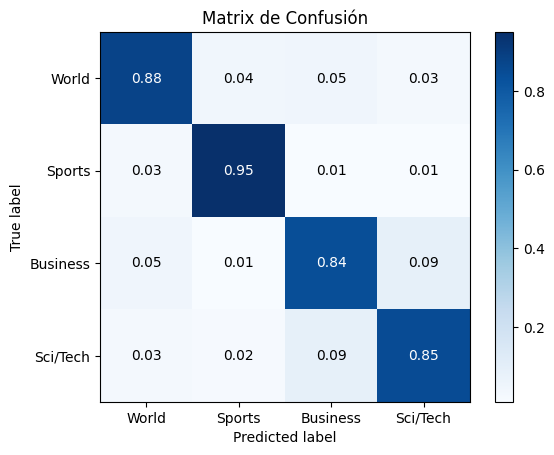

In [26]:
#create_confusion_matrix(rnn_model, test_loader)

# Esta es la función que creamos para la matriz de confusión
def confusion_matrix(model, loader):
    y_true = []
    y_pred = []

    model.eval()
    with torch.no_grad():
        for xi, yi in loader:
            xi = xi.to(device=device, dtype=torch.long)
            scores = model(xi)
            _, pred = scores.max(dim=1)
            y_true.extend(yi.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())

    skplt.metrics.plot_confusion_matrix(y_true, y_pred, normalize=True, title="Matrix de Confusión")
    plt.xticks([0, 1, 2, 3], labels)
    plt.yticks([0, 1, 2, 3], labels)
    plt.show()

# Mostramos la matriz de confusión
confusion_matrix(rnn_model, test_loader)

In [208]:
#help(skplt.metrics.plot_confusion_matrix)
